# VAR shallow glance

In [1]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5MB 6.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [397]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import VAR, acf, pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.base.transform import BoxCox
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

### Data loading

In [538]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)
aus_retail.head()

,A3349335T,A3349627V,A3349338X,A3349398A,A3349468W,A3349336V,A3349337W,A3349397X,A3349399C,A3349874C,A3349871W,A3349790V,A3349556W,A3349791W,A3349401C,A3349873A,A3349872X,A3349709X,A3349792X,A3349789K,A3349555V,A3349565X,A3349414R,A3349799R,A3349642T,A3349413L,A3349564W,A3349416V,A3349643V,A3349483V,A3349722T,A3349727C,A3349641R,A3349639C,A3349415T,A3349349F,A3349563V,A3349350R,A3349640L,A3349566A,...,A3349605F,A3349688X,A3349456L,A3349774V,A3349848X,A3349457R,A3349851L,A3349604C,A3349608L,A3349609R,A3349773T,A3349852R,A3349775W,A3349776X,A3349607K,A3349849A,A3349850K,A3349606J,A3349932R,A3349862V,A3349462J,A3349463K,A3349334R,A3349863W,A3349781T,A3349861T,A3349626T,A3349617R,A3349546T,A3349787F,A3349333L,A3349860R,A3349464L,A3349389X,A3349461F,A3349788J,A3349547V,A3349388W,A3349870V,A3349396W
Series ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-04-01,303.1,41.7,63.9,408.7,65.8,91.8,53.6,211.3,94.0,32.7,126.7,178.3,50.4,22.2,43.0,62.4,178.0,61.8,85.4,147.2,1250.2,257.9,17.3,34.9,310.2,58.2,55.8,59.1,173.1,93.6,26.3,119.9,104.2,42.2,15.6,31.6,34.4,123.7,36.4,48.7,...,1.6,15.5,2.7,4.4,2.6,9.7,3.7,2.2,5.9,10.3,2.3,1.1,2.5,2.2,8.1,4.4,3.2,7.6,57.1,933.4,79.6,149.6,1162.6,200.3,243.4,148.6,592.3,268.5,91.4,359.9,460.1,135.1,64.9,125.6,153.5,479.1,146.3,196.1,342.4,3396.4
1982-05-01,297.8,43.1,64.0,404.9,65.8,102.6,55.4,223.8,105.7,35.6,141.3,202.8,49.9,23.1,45.3,63.1,181.5,60.8,84.8,145.6,1300.0,257.4,18.1,34.6,310.1,62.0,58.4,59.2,179.5,95.3,27.1,122.5,110.2,42.1,15.8,31.5,34.4,123.9,36.2,48.9,...,1.6,15.1,3.0,4.9,3.3,11.1,3.8,2.1,5.9,10.6,2.5,1.0,2.5,2.0,8.0,3.4,3.3,6.7,57.3,920.5,80.8,149.7,1150.9,210.3,268.3,151.0,629.6,289.8,96.8,386.6,502.6,134.9,67.7,128.7,154.8,486.1,145.5,196.6,342.1,3497.9
1982-06-01,298.0,40.3,62.7,401.0,62.3,105.0,48.4,215.7,95.1,32.5,127.6,176.3,48.0,22.8,43.7,59.6,174.1,58.7,80.7,139.4,1234.2,261.2,18.1,34.6,313.9,53.8,53.7,59.8,167.3,85.2,24.3,109.6,96.7,38.5,15.2,29.6,33.5,116.8,35.7,47.1,...,1.7,15.5,2.5,4.8,2.7,9.9,3.2,2.0,5.1,9.9,2.3,1.0,2.5,2.0,7.8,3.6,3.5,7.1,55.3,933.6,77.3,149.0,1160.0,198.7,266.1,142.6,607.4,261.9,88.6,350.5,443.8,128.2,65.5,125.0,148.8,467.5,140.2,188.5,328.7,3357.8
1982-07-01,307.9,40.9,65.6,414.4,68.2,106.0,52.1,226.3,95.3,33.5,128.8,172.6,48.6,23.2,46.5,61.9,180.2,60.3,82.4,142.7,1265.0,266.1,18.9,35.2,320.2,57.9,56.9,59.8,174.5,91.6,25.6,117.2,104.6,38.9,15.2,35.2,33.4,122.7,34.6,47.5,...,1.6,16.1,2.8,5.1,2.4,10.2,3.4,2.1,5.4,8.8,2.6,1.1,2.6,2.0,8.3,4.0,3.5,7.5,56.3,972.6,80.4,153.5,1206.4,208.7,273.5,150.1,632.4,267.2,92.1,359.3,459.1,129.9,68.5,136.6,156.1,491.1,146.5,192.0,338.5,3486.8
1982-08-01,299.2,42.1,62.6,403.8,66.0,96.9,54.2,217.1,82.8,29.4,112.3,169.6,51.3,21.4,44.8,60.7,178.1,56.1,80.7,136.8,1217.6,247.2,19.0,33.8,300.1,59.2,56.7,62.2,178.1,85.2,23.5,108.7,92.5,39.5,14.5,34.7,33.2,122.0,32.5,49.3,...,1.6,15.8,2.8,4.6,2.7,10.1,3.1,2.0,5.0,8.8,2.6,0.9,2.8,2.0,8.4,3.6,3.7,7.3,55.4,923.5,81.6,147.3,1152.5,206.2,262.7,153.7,622.6,241.5,83.7,325.2,438.4,133.0,65.2,134.7,152.8,485.7,138.8,192.7,331.5,3355.9


In [539]:
train_bound = pd.Timestamp('2016-02-01')

In [540]:
train = aus_retail[aus_retail.index <= train_bound].iloc[:, :4]
test = aus_retail[aus_retail.index > train_bound].iloc[:, :4]
train.shape, test.shape

((407, 4), (60, 4))

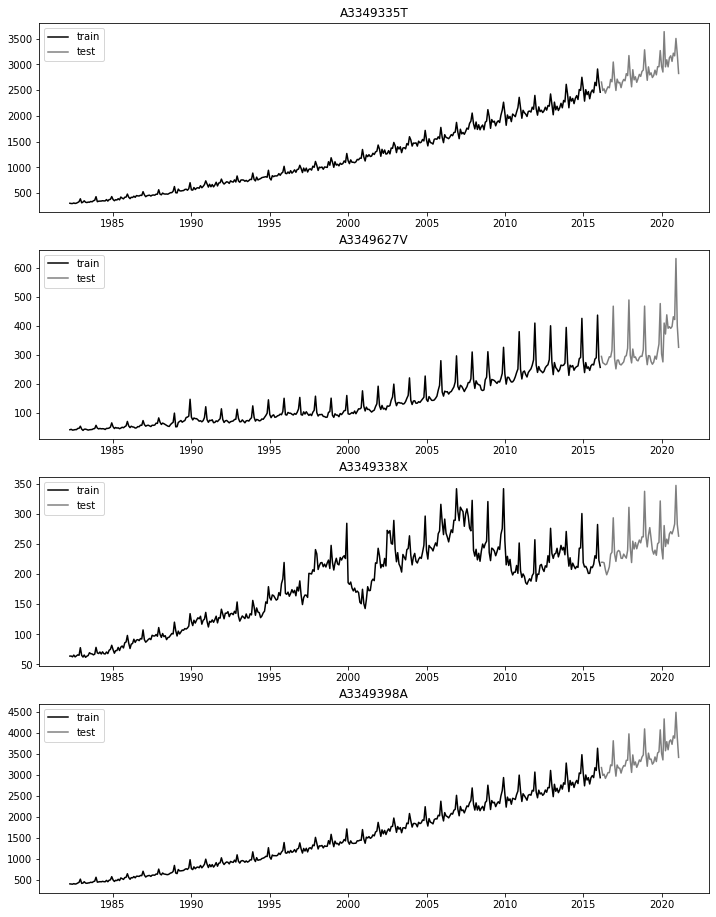

In [541]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.legend()
    plt.title(col)

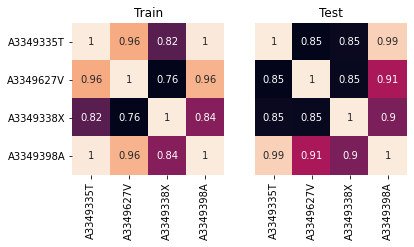

In [229]:
plt.subplot(1, 2, 1)
sns.heatmap(train.corr(), annot=True, square=True, cbar=False)
plt.title('Train')
plt.subplot(1, 2, 2)
sns.heatmap(test.corr(), annot=True, square=True, cbar=False, )
plt.title('Test')
plt.yticks([])
plt.show()

### Data transformation

In [542]:
boxcox_model = BoxCox()

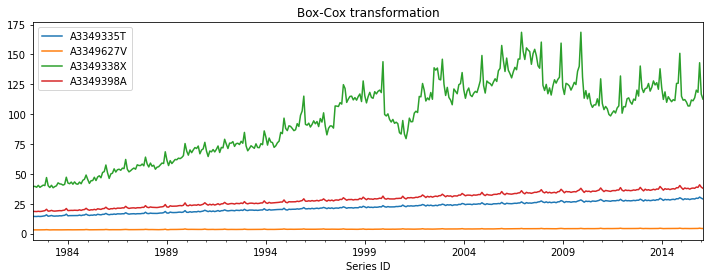

In [543]:
lambds = {}
bc_train = train.copy()
for col in train.columns:
    bc_train[col], lambds[col] = boxcox_model.transform_boxcox(
        train[col].values, method='loglik')
bc_train.plot(figsize=(12, 4))
plt.title('Box-Cox transformation')
plt.show()

In [544]:
lambds

{'A3349335T': 0.2849374963384148,
 'A3349338X': 0.85262045917212,
 'A3349398A': 0.3239342116951898,
 'A3349627V': -0.10305050735646222}

In [545]:
for col in t_train.columns:
    kpss_stat, p_value, lags, crit = kpss(bc_train[col], nlags='auto')
    print(col, 'Stationary' if p_value > 0.05 else 'Non-stationary')

A3349335T Non-stationary
A3349627V Non-stationary
A3349338X Non-stationary
A3349398A Non-stationary


In [546]:
def differencing(ts, periods):
    return ts.diff(periods=periods).dropna()

def integration(ts, periods, original_ts):
    ts_concat = pd.concat([original_ts.iloc[:periods], ts])
    ts_integration = []
    for i in range(periods):
        ts_integration.append(ts_concat.iloc[i::periods].cumsum(axis=0))
    return pd.concat(ts_integration).sort_index()

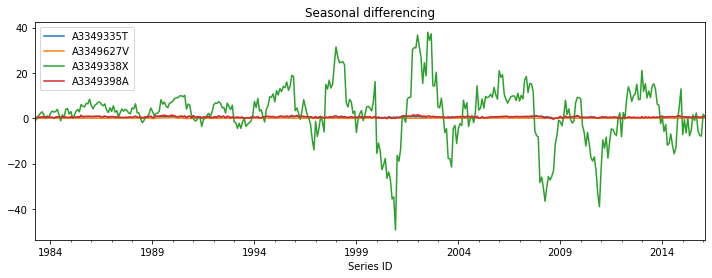

In [547]:
seasonal_lag = 12
t_train = differencing(bc_train, seasonal_lag)
t_train.plot(figsize=(12, 4))
plt.title('Seasonal differencing')
plt.show()

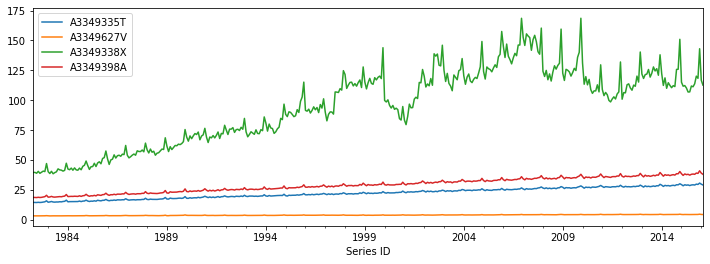

In [548]:
bc_train_rec = integration(t_train, 12, bc_train.iloc[:12])
bc_train_rec.plot(figsize=(12, 4));

In [549]:
for col in t2_train.columns:
    kpss_stat, p_value, lags, crit = kpss(t2_train[col], nlags='auto')
    print(col, 'Stationary' if p_value > 0.05 else 'Non-stationary')

A3349335T Stationary
A3349627V Stationary
A3349338X Stationary
A3349398A Stationary


### VAR fitting

In [550]:
model = VAR(t_train.values)
lores = model.select_order(10, trend='nc')
print('BIC:', lores.bic)

BIC: 2


In [551]:
results = model.fit(maxlags=lores.bic)

### VAR residuals diagnostics

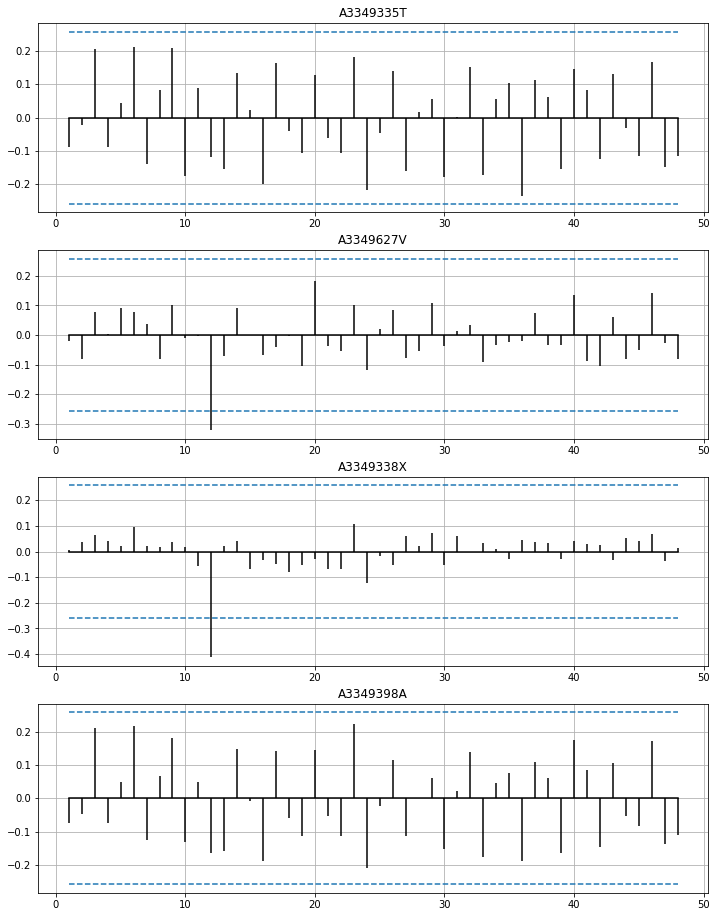

In [552]:
nlags = 48
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(test.columns):
    plt.subplot(4, 1, i+1)
    acf_vals, acf_cint = acf(results.resid[:, i], nlags=nlags, fft=True, alpha=0.05)
    plt.vlines(np.arange(1, nlags + 1), np.zeros(nlags), acf_vals[1:])
    plt.plot(np.arange(1, nlags + 1), np.zeros(nlags), c='black')
    wnoise = 2 / test.shape[0]**(1/2)
    plt.plot([1, nlags], [wnoise, wnoise], c='tab:blue', linestyle='--')
    plt.plot([1, nlags], [-wnoise, -wnoise], c='tab:blue', linestyle='--')
    plt.grid()
    plt.title(col)

In [553]:
results.test_whiteness(nlags=24).summary()

Test statistic,Critical value,p-value,df
733.0,396.8,0.000,352


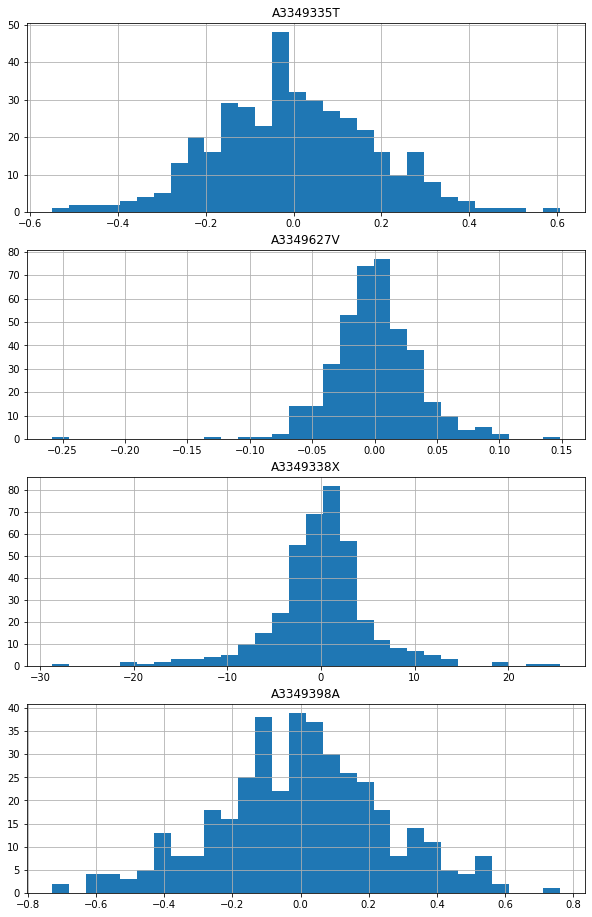

In [554]:
nlags = 48
plt.figure(figsize=(10, 4*4))
for i, col in enumerate(test.columns):
    plt.subplot(4, 1, i+1)
    plt.hist(results.resid[:, i], bins=30)
    plt.title(col)
    plt.grid()

In [555]:
results.test_normality().summary()

Test statistic,Critical value,p-value,df
2264.,15.51,0.000,8


### VAR forecasting

In [556]:
point_forecast, lower_forecast, upper_forecast = results.forecast_interval(
    t_train.values, steps=60, alpha=0.05)
point_forecast = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower_forecast = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper_forecast = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)
point_forecast.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,0.452536,0.029267,0.754939,0.612655
2016-04-01,0.545656,0.029227,1.269577,0.721839
2016-05-01,0.484398,0.028310,1.243293,0.645917
2016-06-01,0.498920,0.027609,1.460960,0.659689
2016-07-01,0.482113,0.027607,1.529038,0.638082


### Inverse transformation

In [560]:
bc_pred = integration(point_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_lower = integration(lower_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_upper = integration(upper_forecast, seasonal_lag, bc_train.iloc[-seasonal_lag:]).iloc[-60:]
bc_pred.shape

(60, 4)

In [561]:
covs = results.forecast_cov(60)
inds = np.arange(results.neqs)
vars = covs[:, inds, inds]
vars = pd.DataFrame(vars, columns=test.columns, index=test.index)
vars.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,0.033353,0.001270,32.716412,0.063601
2016-04-01,0.036227,0.001704,51.082993,0.069039
2016-05-01,0.041679,0.002060,67.721639,0.080958
2016-06-01,0.043236,0.002293,81.260998,0.084978
2016-07-01,0.044530,0.002454,92.625481,0.088774


Bias adjustments inverse transformation

In [562]:
def ba_inv_boxcox(y, lmbda, y_vars):
    if abs(lmbda) <= 1e-19:
        return np.exp(y)*(1 + vars / 2)
    else:
        return (lmbda * y + 1)**(1/lmbda) * (1 + y_vars * (1 - lmbda) / 2 / (lmbda * y + 1)**2)

In [563]:
pred = bc_pred.copy()
lower = bc_lower.copy()
upper = bc_upper.copy()
for col in bc_pred.columns:
    pred[col] = ba_inv_boxcox(bc_pred[col].values, lambds[col], vars[col].values)
    lower[col] = inv_boxcox(bc_lower[col].values, lambds[col])
    upper[col] = inv_boxcox(bc_upper[col].values, lambds[col])
pred.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
2016-03-01,2633.635437,288.520783,214.719292,3134.952119
2016-04-01,2559.440866,267.463220,211.378051,3035.093978
2016-05-01,2604.231285,272.819313,204.036971,3077.140730
2016-06-01,2463.488874,259.650061,204.737254,2923.930374
2016-07-01,2587.647070,276.590452,215.725930,3074.778564


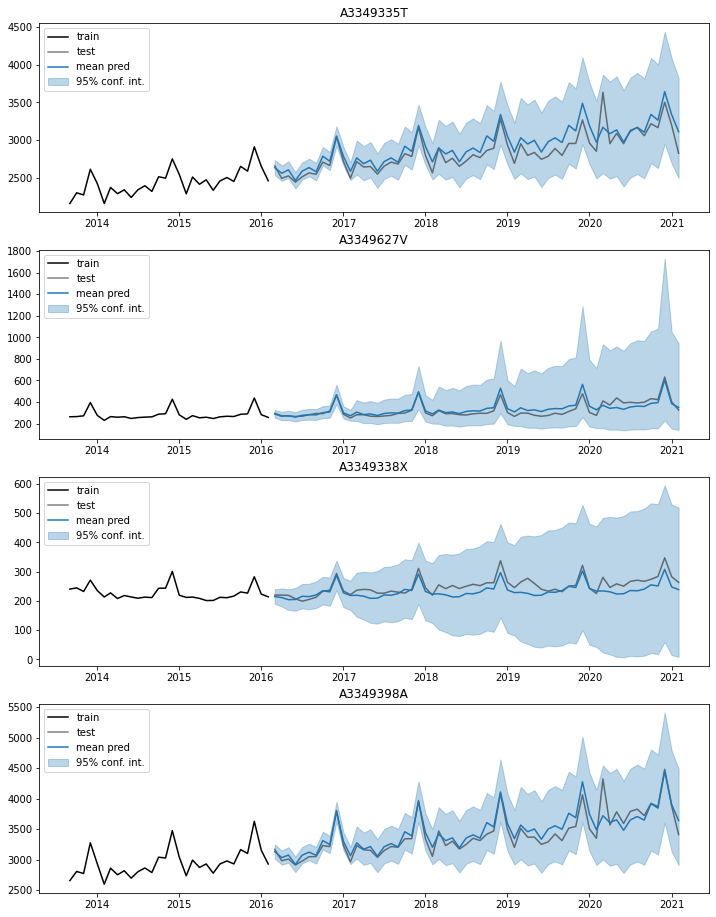

In [564]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-30:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)